In [98]:
%matplotlib inline
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [99]:
# Plot the results for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [100]:
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize

In [101]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np, sper, spar
#pls_par = np.array([-380., -30., 30., 20., 40., 5., 2  ,  4]) 
pls_par = np.array([-580., 10., -10., 20., 30., 1., 2  ,  4]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 

In [102]:
#Changed to mean km/s in p,q space 2018/10/19
reload(mdv)
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_gennorm_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)

                         

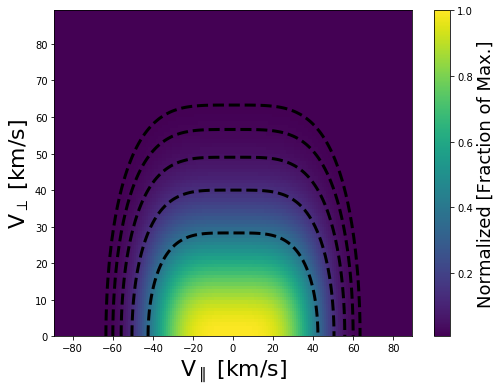

In [103]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [104]:
#multi faraday cup solutions
reload(mff)
fcs,big_arr = mff.create_multi_fc(dis_vdf,15,v_smp=40)

In [105]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8


In [106]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ( (n_angl > 1e-4)) #np.sort(n_angl)[-6]



#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [107]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])


In [108]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [109]:
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n,2,2])


In [110]:
#######Give info on best fit versus real solution######
print(pls_par[:6])
print(pls_par_bad[:6])

[-580.   10.  -10.   20.   30.    1.]
[-586.54330527   29.69997884   29.50115767   17.44121014   48.71238836
    1.1332693 ]


In [111]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_gennorm_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [112]:
reload(mff)
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(mff.gennorm_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':1e-4,'ftol':1e-4,'disp':True})
x2 = time.time()
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 3375
[-580.   10.  -10.   20.   30.    1.    2.    4.]
[-579.99999999   10.00000001   -9.99999995   19.99999997   30.            1.
    1.99999999    4.00000003]
203.859744402


In [113]:
#Initial guess around current guess of 2d VDF
dis_vdf_bad_guess = mdv.make_discrete_gennorm_vdf(powell.x,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
pred_grid = dis_vdf_bad_guess['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad_guess,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


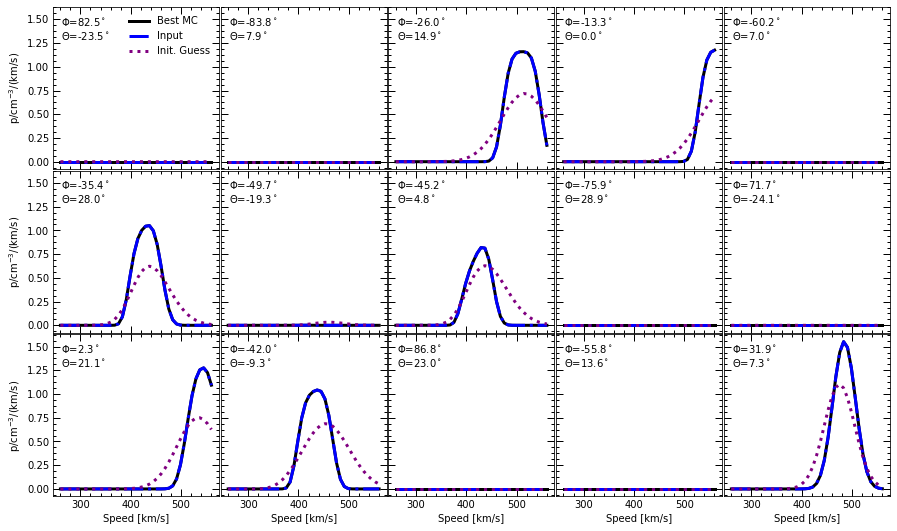

In [114]:
mff.create_fc_grid_plot(fcs)
plt.show()

(<matplotlib.figure.Figure at 0x11234c690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1227830d0>)

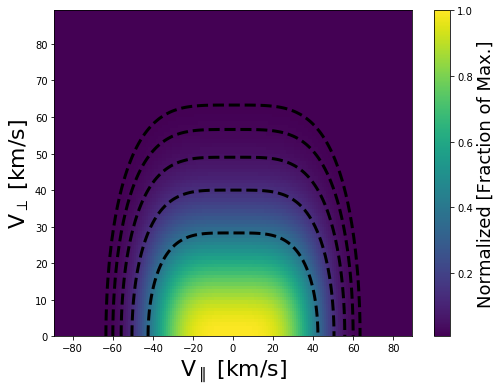

In [115]:
mdv.plot_vdf(dis_vdf_bad_guess)